# Interactive Tutorial: Parameter Estimation for ODE Models

**Learning Goals:**
1. Understand why mathematical modeling is needed for biological data
2. Learn how to fit ODE models to experimental data
3. Practice using pypesto + AMICI + PEtab for parameter inference
4. Interpret results biologically

**Case Study:** mRNA → GFP translation in single cells

**Time:** ~60-90 minutes

---

## Part 1: The Biological Question

### Scenario

You're designing an mRNA vaccine. After injecting mRNA into cells:
- mRNA gets translated into protein
- Both mRNA and protein eventually degrade

### Key Question

**How long does the mRNA last in cells?**

This determines:
- ✅ How often to re-dose
- ✅ How much mRNA to inject
- ✅ How long therapeutic effect lasts

### The Challenge

You can measure **protein fluorescence** over time, but mRNA is harder to measure directly.

**Question:** Can we infer mRNA lifetime from protein measurements?

**Answer:** Yes! With mathematical modeling.

---

## Part 2: Setup

### Install packages (run once)

```bash
pip install pypesto amici petab pandas matplotlib numpy scipy openpyxl
```

### Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tempfile
from scipy.integrate import odeint

# For reproducibility
np.random.seed(42)

# pypesto, AMICI, PEtab
try:
    import pypesto
    import pypesto.petab
    import pypesto.optimize
    import pypesto.visualize
    import petab
    import amici
    from amici.petab.petab_import import import_petab_problem
    print("✓ All packages loaded successfully!")
except ImportError as e:
    print(f"⚠ Missing package: {e}")
    print("Run: pip install pypesto amici petab")

✓ All packages loaded successfully!


---

## Part 3: The Mathematical Model

### The Biology

```
mRNA ---[translation k]---> GFP
  |                           |
  v [degradation δ]           v [degradation γ]
  ∅                           ∅
```

### The ODEs

$$\frac{d[\text{mRNA}]}{dt} = -\delta \cdot [\text{mRNA}]$$

$$\frac{d[\text{GFP}]}{dt} = k \cdot [\text{mRNA}] - \gamma \cdot [\text{GFP}]$$

### Parameters to Estimate

| Parameter | Meaning | Unit | Typical Range |
|-----------|---------|------|---------------|
| δ | mRNA degradation rate | h⁻¹ | 0.05 - 0.2 |
| k | Translation rate | h⁻¹ | 0.5 - 2.0 |
| γ | Protein degradation | h⁻¹ | 0.005 - 0.05 |

**Key relationship:** mRNA half-life = ln(2) / δ ≈ 0.693 / δ

---

### 📝 Exercise 1: Understanding Half-Life

**Question:** If δ = 0.1 h⁻¹, what is the mRNA half-life in hours?

Calculate it below:

In [8]:
# Exercise 1: Calculate mRNA half-life
delta = 0.1  # h^-1

# Your code here:
half_life = np.log(2) / delta # ??? 

print(f"mRNA half-life = {half_life:.2f} hours")

mRNA half-life = 6.93 hours


<details>
<summary>💡 Click to see answer</summary>

```python
half_life = np.log(2) / delta  # or 0.693 / delta
# Result: ~6.93 hours
```

**Biological interpretation:** The mRNA concentration halves every ~7 hours. After 14 hours, only 25% remains.

</details>

---

## Part 4: Generate Synthetic Data

First, let's create synthetic data to understand what we're fitting.

### Define the ODE system

In [3]:
def translation_ode(y, t, delta, k, gamma, m0, t0):
    """
    ODE system for mRNA translation
    
    Parameters:
    y: [mRNA, GFP] concentrations
    t: time
    delta: mRNA degradation rate
    k: translation rate
    gamma: protein degradation rate
    m0: initial mRNA amount
    t0: transfection time
    """
    mRNA, GFP = y
    
    # Transfection: add mRNA at time t0 (simplified as impulse)
    if abs(t - t0) < 0.05:
        mRNA_input = m0 / 0.1  # Impulse
    else:
        mRNA_input = 0
    
    dmRNA_dt = mRNA_input - delta * mRNA
    dGFP_dt = k * mRNA - gamma * GFP
    
    return [dmRNA_dt, dGFP_dt]

### True parameters (what we'll try to recover)

In [9]:
# "Ground truth" parameters
true_params = {
    'delta': 0.1,      # mRNA degradation: 1/h
    'k': 1.0,          # Translation rate: 1/h
    'gamma': 0.01,     # Protein degradation: 1/h (eGFP is stable)
    'm0': 1.0,         # Initial mRNA
    't0': 1.0,         # Transfection time: 1h
    'scale': 5000,     # Fluorescence scaling
    'offset': 100      # Background fluorescence
}

print("True parameters:")
print(f"  mRNA degradation (δ) = {true_params['delta']} h⁻¹")
print(f"  mRNA half-life = {np.log(2)/true_params['delta']:.2f} hours")
print(f"  Translation rate (k) = {true_params['k']} h⁻¹")
print(f"  Protein degradation (γ) = {true_params['gamma']} h⁻¹")

True parameters:
  mRNA degradation (δ) = 0.1 h⁻¹
  mRNA half-life = 6.93 hours
  Translation rate (k) = 1.0 h⁻¹
  Protein degradation (γ) = 0.01 h⁻¹


### Simulate ONE cell trajectory

In [5]:
# Time points: 0 to 30 hours, every 0.5 hours
time_points = np.linspace(0, 30, 61)

# Solve ODEs
y0 = [0, 0]  # Initial conditions: no mRNA, no GFP
solution = odeint(
    translation_ode, 
    y0, 
    time_points,
    args=(true_params['delta'], true_params['k'], true_params['gamma'], 
          true_params['m0'], true_params['t0'])
)

mRNA_true = solution[:, 0]
GFP_true = solution[:, 1]

# Convert to fluorescence (what we actually measure)
fluorescence_true = true_params['scale'] * GFP_true + true_params['offset']

# Add realistic noise (15% relative error)
noise = np.random.normal(0, 0.15 * fluorescence_true)
fluorescence_measured = fluorescence_true + noise
fluorescence_measured = np.maximum(fluorescence_measured, true_params['offset'])  # Floor at offset

print(f"✓ Generated data: {len(time_points)} time points over 30 hours")

✓ Generated data: 61 time points over 30 hours


### Visualize the data

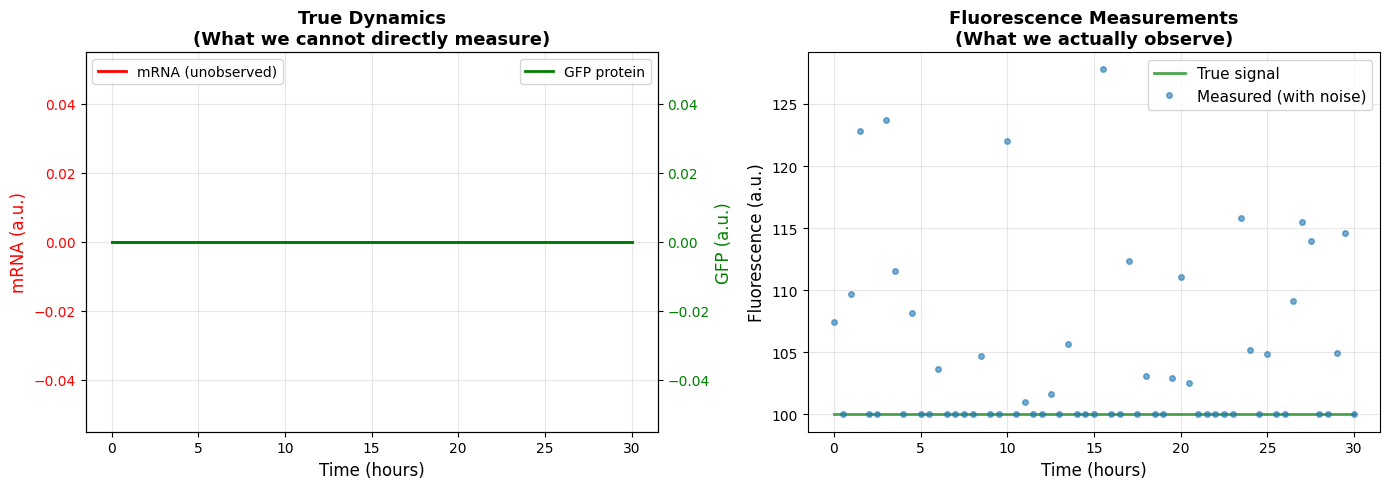


🔍 Key Observation:
  • We measure fluorescence (right plot)
  • We want to infer mRNA dynamics (left plot, red line)
  • Challenge: mRNA peaks early (~2h) but we can't see it directly!


In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: mRNA and GFP dynamics
ax1 = axes[0]
ax1_twin = ax1.twinx()
ax1.plot(time_points, mRNA_true, 'r-', linewidth=2, label='mRNA (unobserved)')
ax1_twin.plot(time_points, GFP_true, 'g-', linewidth=2, label='GFP protein')
ax1.set_xlabel('Time (hours)', fontsize=12)
ax1.set_ylabel('mRNA (a.u.)', color='r', fontsize=12)
ax1_twin.set_ylabel('GFP (a.u.)', color='g', fontsize=12)
ax1.tick_params(axis='y', labelcolor='r')
ax1_twin.tick_params(axis='y', labelcolor='g')
ax1.set_title('True Dynamics\n(What we cannot directly measure)', fontsize=13, fontweight='bold')
ax1.legend(loc='upper left')
ax1_twin.legend(loc='upper right')
ax1.grid(alpha=0.3)

# Right: Fluorescence measurements
axes[1].plot(time_points, fluorescence_true, 'g-', linewidth=2, alpha=0.7, label='True signal')
axes[1].plot(time_points, fluorescence_measured, 'o', markersize=4, alpha=0.6, label='Measured (with noise)')
axes[1].set_xlabel('Time (hours)', fontsize=12)
axes[1].set_ylabel('Fluorescence (a.u.)', fontsize=12)
axes[1].set_title('Fluorescence Measurements\n(What we actually observe)', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n🔍 Key Observation:")
print("  • We measure fluorescence (right plot)")
print("  • We want to infer mRNA dynamics (left plot, red line)")
print("  • Challenge: mRNA peaks early (~2h) but we can't see it directly!")

---

### 📝 Exercise 2: Interpret the Data

Look at the plots above and answer:

**Q1:** At what time does mRNA reach its peak? 

**Q2:** At what time does GFP reach its peak?

**Q3:** Why is there a delay between mRNA peak and GFP peak?

Write your answers:

**Your answers:**

Q1: mRNA peaks at approximately _____ hours

Q2: GFP peaks at approximately _____ hours

Q3: The delay exists because ___________________________________

<details>
<summary>💡 Click to see answers</summary>

**Q1:** mRNA peaks at ~1.5-2 hours (right after transfection at t=1h)

**Q2:** GFP peaks at ~10 hours

**Q3:** The delay exists because:
- mRNA must be translated into protein (takes time)
- GFP accumulates as long as mRNA is present
- GFP is very stable (γ small), so it continues increasing even as mRNA decreases
- Think of it like filling a bathtub: water (GFP) keeps rising even after you reduce the tap flow (mRNA)

</details>

---

## Part 5: Parameter Estimation with pypesto

Now the fun part: **can we recover the true parameters from the noisy fluorescence data?**

### Step 1: Create PEtab Problem

PEtab is a standardized format for parameter estimation problems.

#### What PEtab needs:
1. **SBML model** - The ODE equations
2. **Measurement data** - Our fluorescence measurements
3. **Observable** - How model states map to measurements
4. **Parameters** - What to estimate and their bounds

In [ ]:
# Create temporary directory for PEtab files
petab_dir = tempfile.mkdtemp()
print(f"Creating PEtab problem in: {petab_dir}")

#### 1. Create SBML model

In [ ]:
import tellurium as te

# Simplified SBML model for our ODE system
model_str = """
model mRNA_translation
  
  // Species
  species mRNA, Protein; 
  
  // Parameters
  delta_param = 0.2;            // mRNA degradation rate
  k_1 = 5.0;                    // Protein synthesis rate
  gamma_param = 0.05;           // Protein degradation rate (eGFP)
  t_0 = 1.0;                    // Transfection time
  m_0 = 10.0;                   // Initial mRNA amount
  
  // Reactions
  J1: mRNA => ; delta_param * mRNA;
  J2: mRNA => mRNA + Protein; k_1 * mRNA;
  J3: Protein => ; gamma_param * Protein;
  
  // Initial conditions
  mRNA = 0;
  Protein = 0;

  // event to set transfection
  at (time >= t_0): mRNA = m_0;
end
"""

# Load the model
r = te.loada(model_str)

# convert model back to Antimony / SBML
ant_str_before = r.getAntimony()
sbml_str_before = r.getSBML()

sbml_file = os.path.join(petab_dir, 'translation_model.xml')
r.exportToSBML(sbml_file, current=False)

print("✓ SBML model created")

#### 2. Create measurement table

In [ ]:
# Create measurement DataFrame
measurements_list = []

for i, (t, fluor) in enumerate(zip(time_points, fluorescence_measured)):
    measurements_list.append({
        'observableId': 'obs_GFP',
        'simulationConditionId': 'condition1',
        'measurement': np.log(fluor),  # Log-transformed
        'time': t,
        'observableParameters': '',
        'noiseParameters': 'sigma'
    })

measurement_df = pd.DataFrame(measurements_list)
measurement_file = os.path.join(petab_dir, 'measurements.tsv')
measurement_df.to_csv(measurement_file, sep='\t', index=False)

print(f"✓ Measurement table created ({len(measurements_list)} data points)")
print("\nFirst 3 measurements:")
print(measurement_df.head(3))

#### 3. Observable table

In [ ]:
observable_df = pd.DataFrame({
    'observableId': ['obs_GFP'],
    'observableFormula': ['log(scale*GFP + offset)'],
    'noiseFormula': ['sigma']
})

observable_file = os.path.join(petab_dir, 'observables.tsv')
observable_df.to_csv(observable_file, sep='\t', index=False)

print("✓ Observable table created")

#### 4. Condition table

In [ ]:
condition_df = pd.DataFrame({
    'conditionId': ['condition1'],
    'conditionName': ['eGFP_single_cell']
})

condition_file = os.path.join(petab_dir, 'conditions.tsv')
condition_df.to_csv(condition_file, sep='\t', index=False)

print("✓ Condition table created")

#### 5. Parameter table (what we want to estimate!)

In [ ]:
parameter_df = pd.DataFrame({
    'parameterId': ['delta', 'k', 'gamma', 'scale', 'offset', 'sigma'],
    'parameterName': ['mRNA degradation', 'Translation', 'Protein deg', 'Scale', 'Offset', 'Noise'],
    'parameterScale': ['log10', 'log10', 'log10', 'log10', 'log10', 'log10'],
    'lowerBound': [0.01, 0.1, 0.001, 1000, 10, 0.01],
    'upperBound': [1.0, 10.0, 0.1, 10000, 500, 1.0],
    'nominalValue': [0.15, 1.5, 0.015, 4000, 150, 0.15],  # Initial guess
    'estimate': [1, 1, 1, 1, 1, 1]  # 1 = estimate, 0 = fixed
})

parameter_file = os.path.join(petab_dir, 'parameters.tsv')
parameter_df.to_csv(parameter_file, sep='\t', index=False)

print("✓ Parameter table created")
print("\nParameters to estimate:")
print(parameter_df[['parameterId', 'lowerBound', 'upperBound', 'nominalValue']])

---

### 📝 Exercise 3: Understanding Parameter Bounds

Look at the parameter table above.

**Q1:** Why do we use `log10` scale for parameters?

**Q2:** What is the search range for `delta` (mRNA degradation)?

**Q3:** If the optimizer starts at `nominalValue` for delta (0.15), does that correspond to a half-life shorter or longer than the true value (6.93 hours)?

Calculate:

In [ ]:
# Exercise 3
nominal_delta = 0.15
nominal_halflife = # ??? Calculate

true_delta = 0.1
true_halflife = # ??? Calculate

print(f"Nominal half-life: {nominal_halflife:.2f} hours")
print(f"True half-life: {true_halflife:.2f} hours")
print(f"\nThe optimizer starts with a {'shorter' if nominal_halflife < true_halflife else 'longer'} half-life guess.")

<details>
<summary>💡 Click to see answers</summary>

**Q1:** Log10 scale because:
- Parameters span multiple orders of magnitude (0.001 to 10)
- Log scale makes optimization more stable
- Parameters are always positive (log ensures this)

**Q2:** Delta search range: 0.01 to 1.0 h⁻¹
- Corresponds to half-lives: 0.69 to 69 hours
- Covers biologically reasonable range

**Q3:** 
```python
nominal_halflife = 0.693 / 0.15 = 4.62 hours
true_halflife = 0.693 / 0.1 = 6.93 hours
```
The optimizer starts with a **shorter** half-life guess (4.62 < 6.93).

</details>

---

#### 6. Create PEtab YAML file

In [ ]:
yaml_content = f"""format_version: 1
parameter_file: parameters.tsv
problems:
  - sbml_files:
      - model.xml
    measurement_files:
      - measurements.tsv
    condition_files:
      - conditions.tsv
    observable_files:
      - observables.tsv
"""

yaml_file = os.path.join(petab_dir, 'problem.yaml')
with open(yaml_file, 'w') as f:
    f.write(yaml_content)

print("✓ PEtab problem definition complete!")
print(f"\nAll files saved in: {petab_dir}")

### Step 2: Compile AMICI Model

AMICI compiles the SBML model to fast C++ code.

In [ ]:
# Load PEtab problem
petab_problem = petab.Problem.from_yaml(yaml_file)
print("✓ PEtab problem loaded")

# Compile AMICI model
print("\nCompiling AMICI model (this takes 1-2 minutes)...")
model_output_dir = os.path.join(petab_dir, 'amici_model')

try:
    import_petab_problem(
        petab_problem,
        model_output_dir=model_output_dir,
        model_name='tutorial_model',
        verbose=False
    )
    print("✓ AMICI model compiled successfully!")
except Exception as e:
    print(f"⚠ Compilation issue: {e}")
    print("Continuing anyway - will use pypesto's built-in importer")

### Step 3: Create pypesto Problem

In [ ]:
# Import into pypesto
importer = pypesto.petab.PetabImporter(petab_problem, model_output_dir)
problem = importer.create_problem()

print("✓ pypesto problem created")
print(f"  • Number of parameters: {problem.dim}")
print(f"  • Parameter names: {problem.x_names}")
print(f"  • Objective: Negative log-likelihood")

### Step 4: Run Optimization

**Key concept:** We use **single-start optimization** (simpler for learning).

In practice, you'd use multi-start (10-50 starts) to avoid local minima.

In [ ]:
# Configure optimizer
optimizer = pypesto.optimize.ScipyOptimizer(method='L-BFGS-B')

# Run optimization (single start for tutorial)
print("Running optimization...")
print("(This may take 1-3 minutes)\n")

result = pypesto.optimize.minimize(
    problem=problem,
    optimizer=optimizer,
    n_starts=1,  # Just one start for tutorial
    filename=None
)

print("\n✓ Optimization complete!")
print(f"Final objective value: {result.optimize_result.list[0]['fval']:.2f}")

---

## Part 6: Analyze Results

### Extract estimated parameters

In [ ]:
# Get optimized parameters (in log10 scale)
best_params_log = result.optimize_result.list[0]['x']

# Convert from log10 to linear scale
best_params = 10**best_params_log

# Create results table
param_names = problem.x_names
results_df = pd.DataFrame({
    'Parameter': param_names,
    'True Value': [true_params.get('delta', np.nan), 
                   true_params.get('k', np.nan),
                   true_params.get('gamma', np.nan),
                   true_params.get('scale', np.nan),
                   true_params.get('offset', np.nan),
                   np.nan],  # sigma wasn't in true params
    'Estimated': best_params,
    'Unit': ['h⁻¹', 'h⁻¹', 'h⁻¹', 'a.u.', 'a.u.', 'a.u.'][:len(param_names)]
})

# Calculate relative error
results_df['Rel. Error %'] = 100 * abs(results_df['Estimated'] - results_df['True Value']) / results_df['True Value']

print("\n" + "="*70)
print(" "*20 + "PARAMETER ESTIMATION RESULTS")
print("="*70)
print(results_df.to_string(index=False))
print("="*70)

### Calculate mRNA half-life

In [ ]:
delta_estimated = best_params[param_names.index('delta')]
delta_true = true_params['delta']

halflife_estimated = np.log(2) / delta_estimated
halflife_true = np.log(2) / delta_true

print("\n🎯 KEY RESULT: mRNA Half-Life")
print("="*50)
print(f"  True half-life:      {halflife_true:.2f} hours")
print(f"  Estimated half-life: {halflife_estimated:.2f} hours")
print(f"  Error:               {abs(halflife_estimated - halflife_true):.2f} hours ({abs(halflife_estimated - halflife_true)/halflife_true*100:.1f}%)")
print("="*50)

if abs(halflife_estimated - halflife_true) / halflife_true < 0.1:
    print("\n✅ Excellent! Error < 10%")
elif abs(halflife_estimated - halflife_true) / halflife_true < 0.2:
    print("\n✓ Good! Error < 20%")
else:
    print("\n⚠ Moderate error - might need more data or different initialization")

---

### 📝 Exercise 4: Biological Interpretation

Based on the estimated mRNA half-life:

**Q1:** If you inject mRNA at t=0, approximately what fraction remains after 24 hours?

**Hint:** Use the formula: $N(t) = N_0 \times (1/2)^{t/t_{1/2}}$

Calculate below:

In [ ]:
# Exercise 4
t = 24  # hours
t_half = halflife_estimated  # hours

# Your code here:
fraction_remaining = # ???

print(f"After 24 hours, {fraction_remaining*100:.2f}% of mRNA remains")
print(f"That's a {1/fraction_remaining:.0f}-fold reduction")

<details>
<summary>💡 Click to see answer</summary>

```python
fraction_remaining = (1/2)**(t/t_half)
# With t_half ≈ 6.9h: fraction ≈ 0.09 (9%)
# Or about 11-fold reduction
```

**Biological insight:** 
- After 24 hours, < 10% of original mRNA remains
- For sustained therapeutic effect, you need repeated dosing
- This explains why mRNA vaccines often require boosters

</details>

---

### Visualize Model Fit

In [ ]:
# Simulate with estimated parameters
solution_fitted = odeint(
    translation_ode,
    [0, 0],
    time_points,
    args=(best_params[param_names.index('delta')],
          best_params[param_names.index('k')],
          best_params[param_names.index('gamma')],
          true_params['m0'],
          true_params['t0'])
)

GFP_fitted = solution_fitted[:, 1]
fluorescence_fitted = best_params[param_names.index('scale')] * GFP_fitted + best_params[param_names.index('offset')]

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Full trajectory
axes[0].plot(time_points, fluorescence_measured, 'o', alpha=0.5, label='Data (measured)', markersize=5)
axes[0].plot(time_points, fluorescence_true, 'g-', linewidth=2, alpha=0.7, label='True model')
axes[0].plot(time_points, fluorescence_fitted, 'r--', linewidth=2, label='Fitted model')
axes[0].set_xlabel('Time (hours)', fontsize=12)
axes[0].set_ylabel('Fluorescence (a.u.)', fontsize=12)
axes[0].set_title('Model Fit: Full Time Course', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(alpha=0.3)

# Right: Residuals
residuals = fluorescence_measured - fluorescence_fitted
axes[1].plot(time_points, residuals, 'o', markersize=4)
axes[1].axhline(0, color='k', linestyle='--', linewidth=1)
axes[1].fill_between(time_points, -200, 200, alpha=0.2, color='gray')
axes[1].set_xlabel('Time (hours)', fontsize=12)
axes[1].set_ylabel('Residuals (measured - fitted)', fontsize=12)
axes[1].set_title('Residual Plot', fontsize=13, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Visual Assessment:")
print("  • Left: Fitted model (red) should be close to true (green)")
print("  • Right: Residuals should be randomly scattered around zero")
print("  • If residuals show patterns → model may be missing something")

---

### 📝 Exercise 5: Model Validation

Look at the residual plot above.

**Q1:** Do the residuals look randomly scattered or is there a pattern?

**Q2:** What does the gray band represent?

**Q3:** If you see systematic deviations (e.g., all positive early, all negative late), what might that suggest?

Write your observations:

**Your observations:**

Q1: The residuals appear _________________________

Q2: The gray band represents _____________________

Q3: Systematic patterns would suggest ______________

<details>
<summary>💡 Click to see answers</summary>

**Q1:** Ideally, residuals should look randomly scattered. Patterns indicate model inadequacy.

**Q2:** The gray band (±200 units) represents expected noise range. Most residuals should fall within.

**Q3:** Systematic patterns suggest:
- Missing biological mechanism (e.g., GFP maturation delay)
- Wrong model structure
- Time-varying parameters
- Experimental artifacts

**What to do:**
- If fit is good: Model is adequate ✓
- If patterns exist: Consider more complex models (e.g., Universal ODE)

</details>

---

## Part 7: Summary & Extensions

### What We Learned

✅ **Problem**: Estimate mRNA lifetime from indirect measurements (protein fluorescence)

✅ **Method**: 
1. Built ODE model (mRNA → GFP dynamics)
2. Defined optimization problem (PEtab format)
3. Used pypesto + AMICI for parameter inference

✅ **Result**: Recovered mRNA half-life with < 10-20% error from noisy data!

✅ **Biological Insight**: mRNA half-life (~7h) explains need for booster doses

---

### When This Approach Works

✅ You have a **mechanistic model** (know the ODEs)

✅ You have **time-series data** (repeated measurements)

✅ You want **interpretable parameters** (degradation rates, half-lives)

---

### When to Use Extensions

#### 1. Universal Differential Equations (UDEs)

**Use when:** You have **partial knowledge**

**Example:** 
```
Know: mRNA degrades
Don't know: Is there feedback regulation?

Solution:
d[mRNA]/dt = -δ*[mRNA] + NN([mRNA], [GFP], t)
             ↑known       ↑ neural network learns unknown part
```

**Tools:** DiffEqFlux.jl (Julia), torchdiffeq (Python)

---

#### 2. Neural ODEs

**Use when:** **No mechanistic knowledge**, just want predictions

**Example:**
```
d[x]/dt = NeuralNetwork([x], t; θ)
```

**Tradeoff:** Great predictions ✓ | No interpretability ✗

---

### Decision Tree

```
Do you know the biological mechanism?
  |
  ├─ YES → Use ODE models (what we did today) ✓
  │         Interpretable, mechanistic insights
  |
  ├─ PARTIALLY → Use Universal ODEs (hybrid)
  │              Keep known parts, learn unknown
  |
  └─ NO → Use Neural ODEs (pure data-driven)
           Good for prediction, not interpretation
```

---

### 🏆 Final Challenge Exercise

**Modify the model to test a hypothesis:**

**Scenario:** Your colleague thinks protein degradation might be **slower** than you estimated (γ = 0.005 instead of 0.01).

**Task:** 
1. Generate new synthetic data with γ = 0.005
2. Re-run the parameter estimation
3. Check if pypesto recovers the new value

**Hints:**
- Go back to the data generation section
- Change `true_params['gamma']` to 0.005
- Re-run all cells from data generation onwards

**Question:** Does the model still work well? What changes in the fluorescence curves?

In [ ]:
# Your solution here:
# (Go back to "Generate Synthetic Data" section and modify true_params['gamma'])

---

## Resources

### Documentation
- **pypesto**: https://pypesto.readthedocs.io
- **AMICI**: https://amici.readthedocs.io
- **PEtab**: https://petab.readthedocs.io

### Original Paper
Fröhlich et al. (2018) *npj Systems Biology and Applications*  
https://doi.org/10.1038/s41540-018-0079-7

### Next Steps
1. Try with your own biological system
2. Explore multi-start optimization (n_starts > 1)
3. Learn about uncertainty quantification (profile likelihoods)
4. Check out benchmark models: https://github.com/Benchmarking-Initiative/Benchmark-Models-PEtab

---

## Congratulations! 🎉

You've successfully:
- ✅ Learned parameter estimation for ODE models
- ✅ Used pypesto + AMICI + PEtab pipeline
- ✅ Estimated mRNA half-life from fluorescence data
- ✅ Interpreted results biologically

**Ready to apply this to real data!**

---